In [306]:
from fish.ephys.ephys import load, chop_trials, estimate_onset
from fish.util.fileio import load_image
from glob import glob
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 3
matplotlib.rcParams['ps.fonttype'] = 3
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [307]:
matplotlib.rcParams['font.sans-serif'] = ['Arial']

In [308]:
def trigger_data(triggers, window, fnames, average=False):
    from fish.util.fileio import load_image
    from numpy import array
    
    ims_trial = []
    
    for ind, trig in enumerate(triggers):
        
        tr = []        
        for t_w in window:        
            tr.append(load_image(fnames[trig + t_w]))
        tr = array(tr)
        
        
        if (len(ims_trial) == 0) or not average:
            ims_trial.append(tr)
        if average:
            if ind == 0:
                ims_trial[0] = ims_trial[0].astype('float32') / len(triggers) 
            
            ims_trial[0] += tr.astype('float32') / len(triggers)
        
    if average:         
        return ims_trial[0]
    else:
        return array(ims_trial)

def get_roi(pqim, data):
    return pqim.roi.getArrayRegion(data, pqim.imageItem, axes=(1,2)).mean((1,2))

def unroll(v):
    if v.ndim == 4:
        return v.reshape(v.shape[0], v.shape[1] * v.shape[2], v.shape[3])
    elif v.ndim ==3:
        return v.reshape(v.shape[0] * v.shape[1], v.shape[2])
    
# Need this function to prevent pyqtgraph from leaking memory
def wipe_ims(pq):
    from numpy import zeros

    for iw in pq.images:
      iw.setImage(zeros((1,1))) #<- dummy 1x1 image
      iw.parent().close()
def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

def stackline(x_axis, array, axis, scale, **kwargs):
    for ind, val in enumerate(array):
        axis.plot(x_axis, val - ind * scale, **kwargs)
    axis.set_xlim(x_axis.min(), x_axis.max())
    
def load_muy_mat(fname, head_name='data'):
    from h5py import File 
    data = {}
    with File(fname) as f: 
        for k in f[head_name].keys():
            data[k] = np.squeeze(f[head_name][k][:])
    return data

def triggered_behavior(triggers, window, swims):
    from numpy import array
    trig_ep = []
    for trig in triggers:
        trig_ep.append(swims[trig + window])
    return array(trig_ep)

def standard_clim(axes, clim_scaling=(1,1)):
    clim = np.array([ax.get_images()[0].get_clim() for ax in axes])
    clim = (clim.min() * clim_scaling[0], clim.max() * clim_scaling[1])
    [ax.get_images()[0].set_clim(clim) for ax in axes]    
    
class roi_pq(object):
    def __init__(self, coords, values):
        self.coords = coords
        self.values = values
        
    def __repr__(self):
        return 'An roi with {0} points'.format(len(self.values[0]))

In [43]:
from fish.image.vol import get_metadata

In [305]:
import sys
import json
dirs = {}
if sys.platform != 'win32':
    dirs['base'] = '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/'
else:
    dirs['base'] = 'V:/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/'
dirs['ephys'] = dirs['base'] + 'ephys/'
dirs['raw'] = dirs['base'] + 'raw/'
#dirs['proj'] = dirs['base'] + 'projections/'

z_step = get_metadata(dirs['raw'] + 'ch0.xml')['z_step']
aspect = z_step / (.406 * 4)

dirs['proj_y'] = r'Z:/davis/tmp/20170228/projs_y/'
dirs['proj_z'] = r'Z:/davis/tmp/20170228/projs_z/'
dirs['output'] = 'C:\\Users\\bennettd\\Dropbox (HHMI)\\ngm\\figs\\fig_imaging\\'

from fish.image.vol import get_stack_freq
fs_im = get_stack_freq(dirs['raw'])[0]

with open(dirs['proj_z'] + 'metadata.json', 'r') as f:
    metadata = json.load(f)
fnames = {}
fnames['y'] = glob(dirs['proj_y'] + 't*.tif')
fnames['z'] = glob(dirs['proj_z'] + 't*.tif')
[f.sort() for f in fnames.values()]
print(len(fnames))

2


In [22]:
metadata

{'dff_lims': [-0.5468111634254456, 44.23291778564453],
 'dff_window': 474,
 'raw_data_path': '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/raw/',
 'spatial_downsampling': 4}

In [ ]:
%%time
# Optional: load projections
plr = slice(5000)
projs = np.array([load_image(f) for f in fnames[plr]])

In [94]:
import pyqtgraph as pq
%gui qt

In [ ]:
im = pq.image(unroll(projs))

In [ ]:
rois = {}

In [ ]:
vals, coords = im.roi.getArrayRegion(unroll(projs), im.imageItem, axes=(1,2), returnMappedCoords=True)
rois['waist_g'] = roi_pq(coords, vals.mean((1,2)))

In [ ]:
pl = pq.plot(rois['lc'].values)
pl.plot(rois['waist_g'].values, pen='m')

In [19]:
epdat = load_muy_mat(dirs['ephys'] + 'data.mat')
epdat_raw = load_muy_mat(dirs['ephys'] + 'rawdata.mat', head_name='rawdata')
swims = epdat['fltCh1'] + epdat['fltCh2']
cam = np.where(np.diff(epdat['frame']))[0]

In [20]:
# columns 1 and 2 are the start and stop of stim period
# columns 3 and 4 are start and stop of swim
# the code in the last column of this array: 1 means fish gave up, 3 means fish did not give up
from scipy.io import loadmat
pause_start = np.squeeze(loadmat(dirs['ephys'] + 'pause_start.mat')['pause_start'])
trial_info = loadmat(dirs['ephys'] + 'trial_info.mat')['trial_info']

gu_inds = trial_info[np.where(trial_info[:,-1] == 1)[0],3]
#ngu_inds = pause_start
ngu_inds = np.unique(trial_info[np.where(trial_info[:,-1] == 3)[0],3])

minlen = min(map(len, (gu_inds, ngu_inds))) - 1

gu_inds = gu_inds[:minlen]
ngu_inds = ngu_inds[:minlen]

frames_gu = epdat['frame'][gu_inds].astype('int')
frames_ngu = epdat['frame'][ngu_inds].astype('int')

In [ ]:
from scipy.stats import zscore
x_ep = np.arange(cam[0], cam[-1], 15)
pl = pl = pq.plot(x_ep, zscore(swims[x_ep]))
pl.plot(cam, 5 + zscore(rois['waist_g'].values), pen='m')
pl.plot(cam, 5 + zscore(rois['lc'].values), pen='g')
pl.plot(x_ep, 10 + zscore(epdat_raw['stimVelTotal'][x_ep]), pen='y')

In [28]:
%%time
window_im = np.arange(-20, 20)
trig_gu = {k: trigger_data(frames_gu, window_im, v, average=True) for k,v in fnames.items()}
#trig_ngu = trigger_data(frames_ngu, window_im, fnames, average=True)

from skimage.exposure import rescale_intensity
in_range = (0, 4096)
out_range = tuple(metadata['dff_lims'])
trig_gu = {k: rescale_intensity(v, in_range=in_range, out_range=out_range) for k,v in trig_gu.items()}
#trig_ngu = rescale_intensity(trig_ngu, in_range=in_range, out_range=out_range)

Wall time: 27.4 s


[None, None]

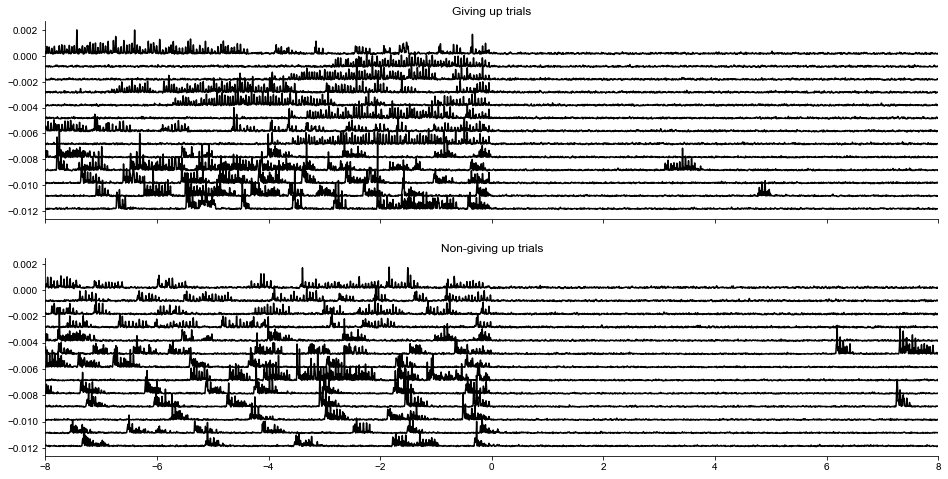

In [29]:
fig, axs = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
window = np.arange(-8 * 6000, 8 * 6000)
x_axis_ep = window / 6000

triggers = gu_inds
trig_ep_gu = triggered_behavior(triggers, window, swims)
scale = .001

stackline(x_axis_ep, trig_ep_gu, axis=axs[0], scale=scale, color='k')
axs[0].title.set_text('Giving up trials')
#[axs[0].axvline(window_im[t] * fs_im, zorder=0, linewidth=5) for t in t_points]

triggers = ngu_inds
trig_ep_ngu = triggered_behavior(ngu_inds, window, swims)
stackline(x_axis_ep, trig_ep_ngu, axis=axs[1], scale=scale, color='k')
    
axs[1].set_xlim(x_axis_ep[0], x_axis_ep[-1])    
axs[1].title.set_text('Non-giving up trials')
[axs_format(ax) for ax in axs]
#[axs[-1].axvline(window_im[t] * fs_im, zorder=0, linewidth=5) for t in t_points]

#plt.savefig(dirs['output'] + 'triggered_behavior.pdf')

In [30]:
#from skimage.io import imsave
#imsave(dirs['output'] + 'triggered_average_gu.tif', trig_gu.astype('float32'), compress=1)
#imsave(dirs['output'] + 'triggered_average_ngu.tif', trig_ngu.astype('float32'), compress=1)

In [114]:
def make_composites(trig_gu, keys, aspect=1):
    """
    Take z and y projections of 2-color imaging data and generate composite projections for each color with the y projections
    rescaled
    """
    from skimage.transform import resize
    from numpy import array, concatenate
    
    y = trig_gu['z'].shape[2]
    y_coords = [slice(0, y//2), slice(y//2,None)]    
    composites = {}
    for ind, k in enumerate(keys):
        y_proj = trig_gu['y'][:, ind, ::-1, :]
        new_shape = array(y_proj.shape)
        new_shape[1] *= aspect
        new_shape = new_shape.astype('int')
        composites[k] = concatenate([trig_gu['z'].max(1)[:,y_coords[ind]], resize(y_proj, new_shape, preserve_range=True, mode='reflect')], axis=1)
    
    return composites

In [230]:
# generate and threshold composites
composites = make_composites(trig_gu, aspect=aspect, keys=['g','n'])
thr = .001
masks = {k: v.std(0) > thr for k,v in composites.items()}
composites = {k: v * masks[k] for k,v in composites.items()}

In [275]:
tmp = ax.get_position()

In [278]:
tmp.extents[2] - tmp.extents[0]

0.2776102735901731

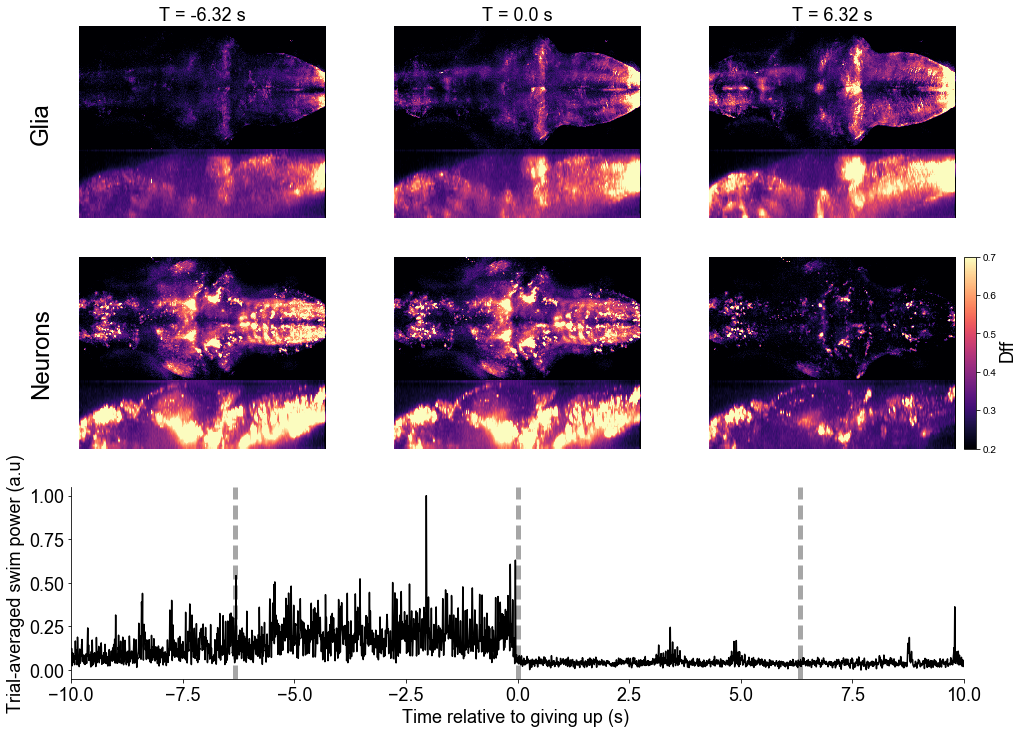

In [312]:
import matplotlib.gridspec as gridspec
from skimage.exposure import adjust_gamma, rescale_intensity 
to_show = [-4, 0, 4]
t_points = [np.where(window_im == t)[0][0] for t in to_show]
vol = composites
triggers = gu_inds
cmap='magma'
gamma = 1
fs_ep = 6000
window_ep = np.arange(-10 * fs_ep, 10 * fs_ep)
x_axis_ep = window_ep / fs_ep
font = {'family' : 'sans-serif',
       'weight' : 'normal',
       'size' : 18}
trig_ep_gu = triggered_behavior(triggers, window_ep, swims)
scale = .001

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(3, len(t_points), height_ratios=[1, 1, 1])

axs_ts = plt.subplot(gs[2,:])
axs_ims = {}
axs_ims['g'] = [plt.subplot(gs[0,t]) for t in range(len(t_points))]
axs_ims['n'] = [plt.subplot(gs[1,t]) for t in range(len(t_points))]

labels = {'g': 'Glia', 'n': 'Neurons'}

# plot images
clims = [.2, .7]
for ind_t, val_t in enumerate(t_points):
    for key_c, val_c in vol.items():            
        ax = axs_ims[key_c][ind_t]
        im = ax.imshow(val_c[val_t], cmap=cmap, clim=clims)
        ax.axis('off')
        ax.title.set_fontsize(18)
        ax_pos = ax.get_position()
        if key_c == 'g':
            ax.title.set_text(f'T = {window_im[val_t] * fs_im} s')    
        if ind_t == 0:
            ax.annotate(labels[key_c],(-.2,.5), xycoords='axes fraction', fontsize=24, rotation=90, verticalalignment='center')
        if (ind_t == len(t_points)-1) & (key_c == 'n'):                  
            cax = fig.add_axes([ax_pos.extents[2], ax_pos.extents[1], .01, ax_pos.height])
            plt.colorbar(im, cax, orientation='vertical')
            cax.annotate('Dff', (1,.5), xytext=(3,.5), xycoords='axes fraction', rotation=90, fontsize=18)

#plt.tight_layout()
# plot corresponding timeseries
axs_ts.plot(x_axis_ep, rescale_intensity(trig_ep_gu.mean(0), out_range=(0,1)), color='k')
axs_ts.set_xlim(x_axis_ep[0], x_axis_ep[-1])
axs_ts.set_ylabel('Trial-averaged swim power (a.u)', fontsize=18)
axs_ts.set_xlabel('Time relative to giving up (s) ', fontsize=18)

[axs_ts.tick_params(axis='both', which=order, labelsize=18) for order in ['major', 'minor']]
[axs_ts.axvline(window_im[t] * fs_im, zorder=0, linewidth=5, color='grey', linestyle='--',alpha=.7) for t in t_points]
axs_format(axs_ts)

plt.savefig(dirs['output'] + 'triggered_average_gu.pdf', transparent=True)